# Metadata

Nguồn dataset:
- https://github.com/hromi/SMILEsmileD
- https://www.kaggle.com/datasets/chazzer/smiling-or-not-face-data

In [1]:
import os, shutil, random
import tensorflow as tf
import matplotlib.pyplot as plt
import albumentations as A
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import os
import random
import albumentations as A
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (EarlyStopping,ModelCheckpoint)
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import cv2

2024-06-11 15:45:32.112144: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 15:45:33.222449: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
ERROR:albumentations.check_version:Error fetching version info
Traceback (most recent call last):
  File "/home/vohoang/miniconda3/envs/tfgpu_2.16.1/lib/python3.10/urllib/request.py", line 1348, in do_open
    h.request(req.get_method(), req.selector, req.data, headers,
  File "/home/vohoang/miniconda3/envs/tfgpu_2.16.1/lib/python3.10/http/client.py", line 1283, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/home/vohoang/miniconda3/envs/tfgpu_2.16.1/lib/python3.10/http/client.py", line 1329, in _send_request
    self.e

In [2]:
CONFIGURATION = {
    "CLASS_NAMES": ['Smile', 'Not Smile'], 
    "TRAIN_RATIO": 0.7,
    "IMAGE_SIZE": (64, 64),
    "VAL_RATIO": 0.2,
    "TEST_RATIO": 0.1,
    "NUM_EPOCHS": 10,
    "BATCH_SIZE": 32,
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 200,
    "REGULARIZATION_RATE": 0.0,
}

## Data loading

In [3]:
# Convert toàn bộ ảnh màu sang grayscale

# Đường dẫn tới thư mục chứa ảnh màu
input_dir = 'dataset/smiling-or-not-face-data'
# Đường dẫn tới thư mục lưu ảnh grayscale
output_dir = 'dataset/smiling-or-not-face-data-grayscale'

# Tạo thư mục lưu ảnh grayscale nếu chưa tồn tại
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Duyệt qua từng thư mục trong thư mục chứa ảnh màu
for folder in os.listdir(input_dir):
    folder_path = os.path.join(input_dir, folder)
    if os.path.isdir(folder_path):
        # Tạo thư mục tương ứng trong thư mục lưu ảnh grayscale
        output_folder_path = os.path.join(output_dir, folder)
        if not os.path.exists(output_folder_path):
            os.makedirs(output_folder_path)
        
        # Duyệt qua từng ảnh trong thư mục hiện tại
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            # Đọc ảnh màu
            image = cv2.imread(image_path)
            # Chuyển đổi sang ảnh grayscale
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # Lưu ảnh grayscale vào thư mục đích
            output_image_path = os.path.join(output_folder_path, filename)
            cv2.imwrite(output_image_path, gray_image)

In [4]:
# Đọc ảnh
path = 'dataset/smiling-or-not-face-data-grayscale/Not Smile/Ian_Huntley_0001.jpg'
img = cv2.imread(path)

# Kiểm tra số chiều của ma trận ảnh grayscale
num_dimensions = img.ndim

print("Số chiều của ma trận ảnh:", num_dimensions)

Số chiều của ma trận ảnh: 3


In [5]:
dataset_dirs = ['dataset/smiling-or-not-face-data-grayscale', 'dataset/SMILEsmileD']

In [6]:
# Tạo thư mục mới gộp tất cả các ảnh trong các dataset lại và chia chúng thành 3 tập train/val/test
merged_dataset_dir = 'merged_dataset'
train_dir = os.path.join(merged_dataset_dir, 'train')
val_dir = os.path.join(merged_dataset_dir, 'val')
test_dir = os.path.join(merged_dataset_dir, 'test')

# Tạo các thư mục đích nếu chưa tồn tại
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(os.path.join(train_dir, 'Smile'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'Not Smile'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'Smile'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'Not Smile'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'Smile'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'Not Smile'), exist_ok=True)

In [7]:
def split_files(file_list, train_ratio, val_ratio, test_ratio):
    random.shuffle(file_list)
    train_split = int(train_ratio * len(file_list))
    val_split = int((train_ratio + val_ratio) * len(file_list))
    train_files = file_list[:train_split]
    val_files = file_list[train_split:val_split]
    test_files = file_list[val_split:]
    return train_files, val_files, test_files

# Hợp nhất và chia các ảnh vào thư mục tương ứng
for class_name in CONFIGURATION['CLASS_NAMES']:
    all_files = []
    for dataset_dir in dataset_dirs:
        src_dir = os.path.join(dataset_dir, class_name)
        file_list = os.listdir(src_dir)
        for file_name in file_list:
            all_files.append(os.path.join(src_dir, file_name))
    
    train_files, val_files, test_files = split_files(all_files, CONFIGURATION['TRAIN_RATIO'], CONFIGURATION['VAL_RATIO'], CONFIGURATION['TEST_RATIO'])
    
    # Đếm số lượng file đã được sao chép để thêm vào tên mới
    train_count = 1
    val_count = 1
    test_count = 1
    
    for file_path in train_files:
        new_file_name = os.path.join(train_dir, class_name, f"{train_count}_{os.path.basename(file_path)}")
        shutil.copy(file_path, new_file_name)
        train_count += 1
    
    for file_path in val_files: 
        new_file_name = os.path.join(val_dir, class_name, f"{val_count}_{os.path.basename(file_path)}")
        shutil.copy(file_path, new_file_name)
        val_count += 1
    
    for file_path in test_files:
        new_file_name = os.path.join(test_dir, class_name, f"{test_count}_{os.path.basename(file_path)}")
        shutil.copy(file_path, new_file_name)
        test_count += 1

In [8]:
def count_images_in_folder(folder_path):
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']  # Các định dạng ảnh phổ biến

    image_count = 0
    for file_name in os.listdir(folder_path):
        if any(file_name.lower().endswith(ext) for ext in image_extensions):
            image_count += 1

    return image_count

folder_path = 'dataset/smiling-or-not-face-data/Smile'
print("Số lượng ảnh trong thư mục là:", count_images_in_folder(folder_path))


Số lượng ảnh trong thư mục là: 600


In [9]:
# Đường dẫn đến các thư mục dataset
train_directory = os.path.join(merged_dataset_dir, 'train')
val_directory = os.path.join(merged_dataset_dir, 'val')
test_directory = os.path.join(merged_dataset_dir, 'test')

# Load train dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='binary',  # 'categorical': One hot coding
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=CONFIGURATION['IMAGE_SIZE'],
    shuffle=True,
    seed=42
)

# Load validation dataset
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='binary',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=CONFIGURATION['IMAGE_SIZE'],
    shuffle=True,
    seed=42
)

# Load test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory,
    labels='inferred',
    label_mode='binary',
    batch_size=1,
    image_size=CONFIGURATION['IMAGE_SIZE'],
    shuffle=True,
    seed=42
)

Found 10062 files belonging to 2 classes.


2024-06-11 15:45:41.585610: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-11 15:45:41.824616: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-11 15:45:41.824900: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 2875 files belonging to 2 classes.
Found 1437 files belonging to 2 classes.


## Data Visualization

In [10]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

2024-06-11 15:45:43.288115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


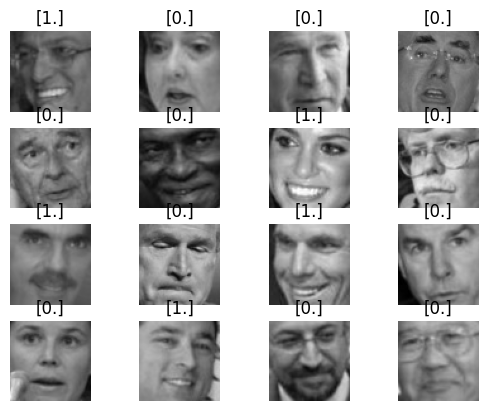

In [11]:
# Vẽ 16 hình ảnh từ tập train và ghi nhãn làm tiêu đề cho mỗi hình ảnh
for index, (images, labels) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, index + 1)
    plt.imshow(images[0].numpy().astype("uint8"))  # Chọn một hình ảnh từ batch
    plt.title(labels[0].numpy())  # Sử dụng giá trị nhãn trực tiếp làm tiêu đề
    plt.axis('off')

plt.show()

Kết luận [1.] là cười [0.] là không cười, khi su dung binary luc load thi ket qua la 1 mang numpy

In [12]:
# Đếm số lượng mẫu trong train_dataset
num_train_samples = train_dataset.reduce(0, lambda x, _: x + tf.shape(_[0])[0]).numpy()
num_val_samples = val_dataset.reduce(0, lambda x, _: x + tf.shape(_[0])[0]).numpy()
num_test_samples = test_dataset.reduce(0, lambda x, _: x + tf.shape(_[0])[0]).numpy()

print("Số lượng mẫu trong train_dataset:", num_train_samples)
print("Số lượng mẫu trong val_dataset:", num_val_samples)
print("Số lượng mẫu trong test_dataset:", num_test_samples)

Số lượng mẫu trong train_dataset: 10062
Số lượng mẫu trong val_dataset: 2875
Số lượng mẫu trong test_dataset: 1437


2024-06-11 15:45:44.186104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-11 15:45:44.253565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-11 15:45:44.505668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


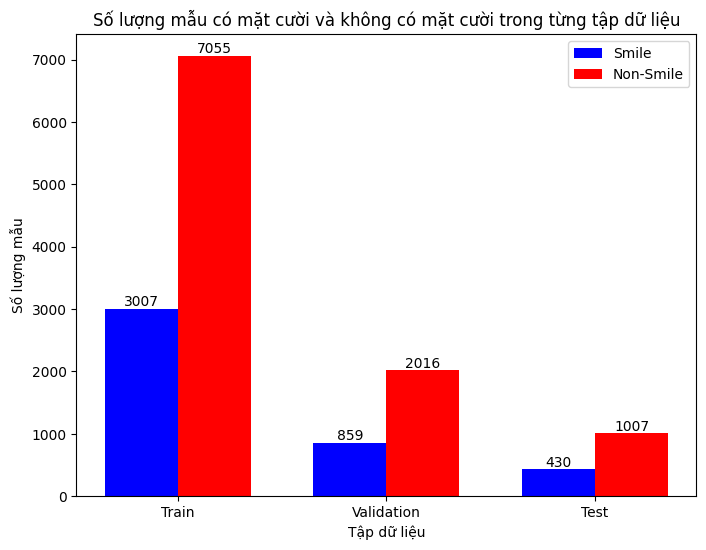

In [13]:
def count_smiles(dataset):
    smile_counts = 0
    non_smile_counts = 0
    for _, labels in dataset:
        for label in labels.numpy():
            if label == 1:  # Kiểm tra xem nhãn có phải là mặt cười không
                smile_counts += 1
            else:
                non_smile_counts += 1
    return smile_counts, non_smile_counts

# Tính số lượng mẫu trong từng tập dữ liệu
train_smile_counts, train_non_smile_counts = count_smiles(train_dataset)
val_smile_counts, val_non_smile_counts = count_smiles(val_dataset)
test_smile_counts, test_non_smile_counts = count_smiles(test_dataset)
# Biểu đồ
labels = ['Train', 'Validation', 'Test']
smile_counts = [train_smile_counts, val_smile_counts, test_smile_counts]
non_smile_counts = [num_train_samples - train_smile_counts, num_val_samples - val_smile_counts, num_test_samples - test_smile_counts]

x = range(len(labels))  # Vị trí của các nhãn trên trục x

plt.figure(figsize=(8, 6))
bar_width = 0.35
plt.bar(x, smile_counts, width=bar_width, color='b', align='center', label='Smile')
plt.bar([i + bar_width for i in x], non_smile_counts, width=bar_width, color='r', align='center', label='Non-Smile')
# Ghi số lượng chính xác lên đầu mỗi thanh cột
for i in range(len(labels)):
    plt.text(i, smile_counts[i], str(smile_counts[i]), ha='center', va='bottom')
    plt.text(i + bar_width, non_smile_counts[i], str(non_smile_counts[i]), ha='center', va='bottom')
plt.xlabel('Tập dữ liệu')
plt.ylabel('Số lượng mẫu')
plt.title('Số lượng mẫu có mặt cười và không có mặt cười trong từng tập dữ liệu')
plt.xticks([i + bar_width / 2 for i in x], labels)
plt.legend()
plt.show()

## Data Agumentation

*Mục đích: Dữ liệu được sử dụng để đưa vào mạng ResNet-18 và ResNet-34*

**Vấn đề 0: Các mạng neutron hiện đại như AlexNet, VGG Net, ResNet, Efficient đều được xây dựng với**
- image có size 224 * 224
- Dữ liệu lên đến hàng trăm triệu ảnh
=> Có thể model này hoạt động không tốt nhất với các với bài toán này do các mạng trên được thiết kế để xây dựng cho các bài toán trên. Tuy nhiên những mạng này thường cho kết quả tốt với các 

**Vấn đề 1: Học thiên vị do dữ liệu Smile bằng 1 nửa so với dữ liệu Non Smile**

- <span style="color:green">Giải pháp 1: Undersampling</span>
    - Loại bỏ 1 số mẫu từ lớp nhiều hơn để cân bằng lượng mẫu giữa các class
- <span style="color:green">Giải pháp 2: Oversampling</span>
    - Sao chép hoặc tạo mới các image để bổ sung vào class ít mẫu hơn (Phổ biến nhất là phươnng pháp STMOE, Random Oversampling)
        - Random Oversampling: sao chép ngẫu nhiên các mẫu từ lớp ít để làm cho số lượng mẫu của lớp ít bằng lớp đa số (nếu dùng cách này có thể dẫn đến overfitting khi 1 ảnh được lặp lại quá nhiều)
        - STMOTE (Synthetic Minority Over-sampling Technique): Thay vì sao chép các mẫu từ lớp ít, SMOTE tạo ra các mẫu mới dựa trên các mẫu có sẵn. Cụ thể, nó chọn ra các mẫu gần nhau/giống nhau nhất và tạo ra các mẫu mới bằng cách kết hợp các đặc điểm của các mẫu này. Điều này giúp tạo ra các mẫu mới mà vẫn giữ được đặc tính của lớp ít mẫu.
- <span style="color:green">Giải pháp 3: Weighted Loss Function</span>
    - Điều chỉnh trọng số của các mẫu trong hàm mất mát sao cho mẫu của lớp ít được coi trọng hơn so với mẫu của lớp nhiều
- <span style="color:green">Giải pháp 4: Data Augmentation</span>
    - Tạo ra thêm nhiều image mới bằng cách xoay phóng, lật, điều chỉnh độ sáng, ...

*Kết luận 1: Sử dụng giải pháp Oversampling - STMOTE. Triển khai bằng cách sử dụng thư viện <a href="https://imbalanced-learn.org/stable/" style="color:red">imbalanced-learn</a>*

- Cách imbalanced-learn hoạt động với STMOTE
    - B1: Chọn những sample gần nhau. Được thực hiện bằng nhiều cách khác nhau, thường được thực hiện bởi các kỹ thuật như k-nearest neighbors
    - B2: Tạo sample mới dựa trên những sample đã chọn và nằm trong không gian đặc trưng của các mẫu đó. Thường lấy trung bình trọng số của các mẫu đã chọn
    - B3: Thêm mẫu mới vào class để cải thiện số lượng

- Thư viện imbalanced-learn thường chỉ hoạt động với dữ liệu dạng array, cần convert nó về dạng array

*Ket luan 2: Khong dung duoc giai phap nay. Tensorflow luon co 1 loi pho bien khi lam viec voi numpy => Chua giai quyet duoc, co 7k anh, khi chuyen sang numpy thi het VRAM*

In [14]:
# Undersampling
def undersampling(dataset_dir):
    # Đường dẫn đến thư mục "Non Smile"
    non_smile_dir = os.path.join(dataset_dir, 'Not Smile')
    
    # Danh sách tất cả các file trong thư mục "Non Smile"
    files = os.listdir(non_smile_dir)
    
    # Số lượng mẫu muốn bo
    target_size = train_non_smile_counts-train_smile_counts
    
    # Lấy một nửa số lượng mẫu ngẫu nhiên từ thư mục "Non Smile"
    sampled_files = random.sample(files, target_size)
    
    # Xóa các mẫu đã lấy ra khỏi thư mục "Non Smile"
    for file_name in sampled_files:
        file_path = os.path.join(non_smile_dir, file_name)
        os.remove(file_path)

In [15]:
undersampling(train_dir)

In [16]:
# Load Lai trainset sau khi undersampling
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='binary',  # 'categorical': One hot coding
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=CONFIGURATION['IMAGE_SIZE'],
    shuffle=True,
    seed=42
)

Found 6014 files belonging to 2 classes.


In [17]:
train_smile_counts, train_non_smile_counts = count_smiles(train_dataset)
print(f"So anh mat cuoi: {train_smile_counts}")
print(f"So anh mat cuoi: {train_non_smile_counts}")

So anh mat cuoi: 3007
So anh mat cuoi: 3007


2024-06-11 15:45:45.047298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


**Vấn đề 3: Data Agumentation. Thay đổi train set sau mỗi epoch (lần trước train luôn bị overfitting là do đây)**

- Data Agumentaion là 1 kỹ thuật phổ biến trong học sâu để tăng tính tổng quát hóa khi train.
- Training set sẽ thay đổi ngẫu nhiên sau mỗi epoch
- Các cách thực hiện thay đổi tập dữ liệu huấn luyện mỗi epoch có thể bao gồm:
    - Rotation(Xoay): xoay 1 góc ngẫu nhiên
    - Scaling(Phóng to): Phóng to hoặc thu nhỏ 1 cách ngẫu nhiên
    - Fiipping(Lật): Lật ảnh theo ngang dọc ngẫu nhiên
    - Brightness/Contrast: Tăng hoặc giảm độ sáng/tương phản ngẫu nhiên
    - Color Shifting: Thay đổi 1 chút các thành phần màu sắc

*Kết luận: Thực hiện Data Agumentation bằng thư viện <a href="https://albumentations.ai/" style="color:red">Albumentation</a>*

- Kinh nhiem: Neu lam viec voi tap du lieu lon thi nen de xac xuat trong khoang (0.1,0.3), khi du lieu nho thi day xac xuat len (0.4-0.5)
- Trong bai toan nay co 29k anh can train cung du lon nen em de xac xuat la 0.1-0.3

In [18]:
# Thiết lập các phép biến đổi với Albumentations. Điều này giúp mô hình trở nên tổng quát hơn và hoạt động tốt hơn trên dữ liệu chưa thấy trước đó
transforms = A.Compose([
    A.HorizontalFlip(p=0.5), # Random quay ngang dọc, giúp model học từ 2 phía
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, always_apply=False, p=0.5),  # Random độ sáng và tương phản ảnh giúp model học trong các điều kiện ánh sáng khác nhau
    A.Rotate(limit=10, p=0.5),  # Xoay ngẫu nhiên trong khoảng [-20, 20], giúp mô hình học cách phân loại dù khuôn mặt có bị xoay nhẹ.
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.5),  # Dịch chuyển, phóng to/thu nhỏ, và xoay ảnh ngẫu nhiên.
    A.Affine(shear=10, p=0.5),  # Cắt ảnh ngẫu nhiên, giảm xuống 10 để tránh biến đổi quá mạnh
    A.PadIfNeeded(min_height=CONFIGURATION['IMAGE_SIZE'][0], min_width=CONFIGURATION['IMAGE_SIZE'][1], border_mode=cv2.BORDER_REFLECT_101, p=1.0)  # Điền giá trị cho các pixel mới sau khi áp dụng biến đổi, đảm bảo kích thước ảnh là 64*64
])

def aug_albument(image):
  data = {"image":image}
  image = transforms(**data)
  image = image["image"]
  image = tf.cast(image/255., tf.float32) # Normalize anh
  return image
  
def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_albument, inp=[image], Tout=tf.float32)
    return aug_img, label

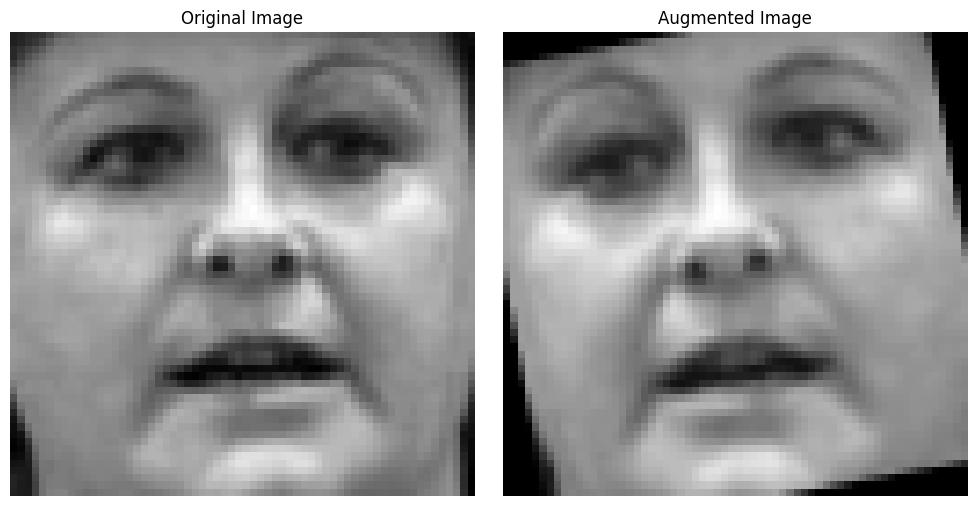

In [20]:
# Hàm để hiển thị ảnh gốc và ảnh đã tăng cường dữ liệu
def visualize_augmentations(original_image, augmented_image):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax[0].imshow(original_image, cmap='gray')  # Hiển thị ảnh gốc dưới dạng grayscale
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    
    ax[1].imshow(augmented_image, cmap='gray')  # Hiển thị ảnh tăng cường dữ liệu dưới dạng grayscale
    ax[1].set_title('Augmented Image')
    ax[1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Đọc ảnh mẫu để thử nghiệm
image_path = 'under_sampling/merged_dataset/train/Not Smile/2_10916.jpg'  # Thay bằng đường dẫn đến ảnh của bạn
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Đọc ảnh dưới dạng grayscale

# Áp dụng các phép biến đổi
augmented_image = aug_albument(original_image)

# Hiển thị ảnh gốc và ảnh sau khi tăng cường
visualize_augmentations(original_image, augmented_image)

In [21]:
# Normalize images in the datasets
def normalize(image, label):
    image = tf.cast(image / 255.0, tf.float32)
    return image, label

train_dataset = train_dataset.map(normalize)
val_dataset = val_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

# Modeling

Su dung kien truc Res50 de train

## ResNet50

Resnet co ty le loi thap hon ca so voi ALex va VGG net, chi tiet xem research

Diem yeu cua Alex va VGG net la no chi hoat dong tot khi layer o 1 khoang nhat dinh, khi mang neutron sau hon thi ket qua cho ra te hon

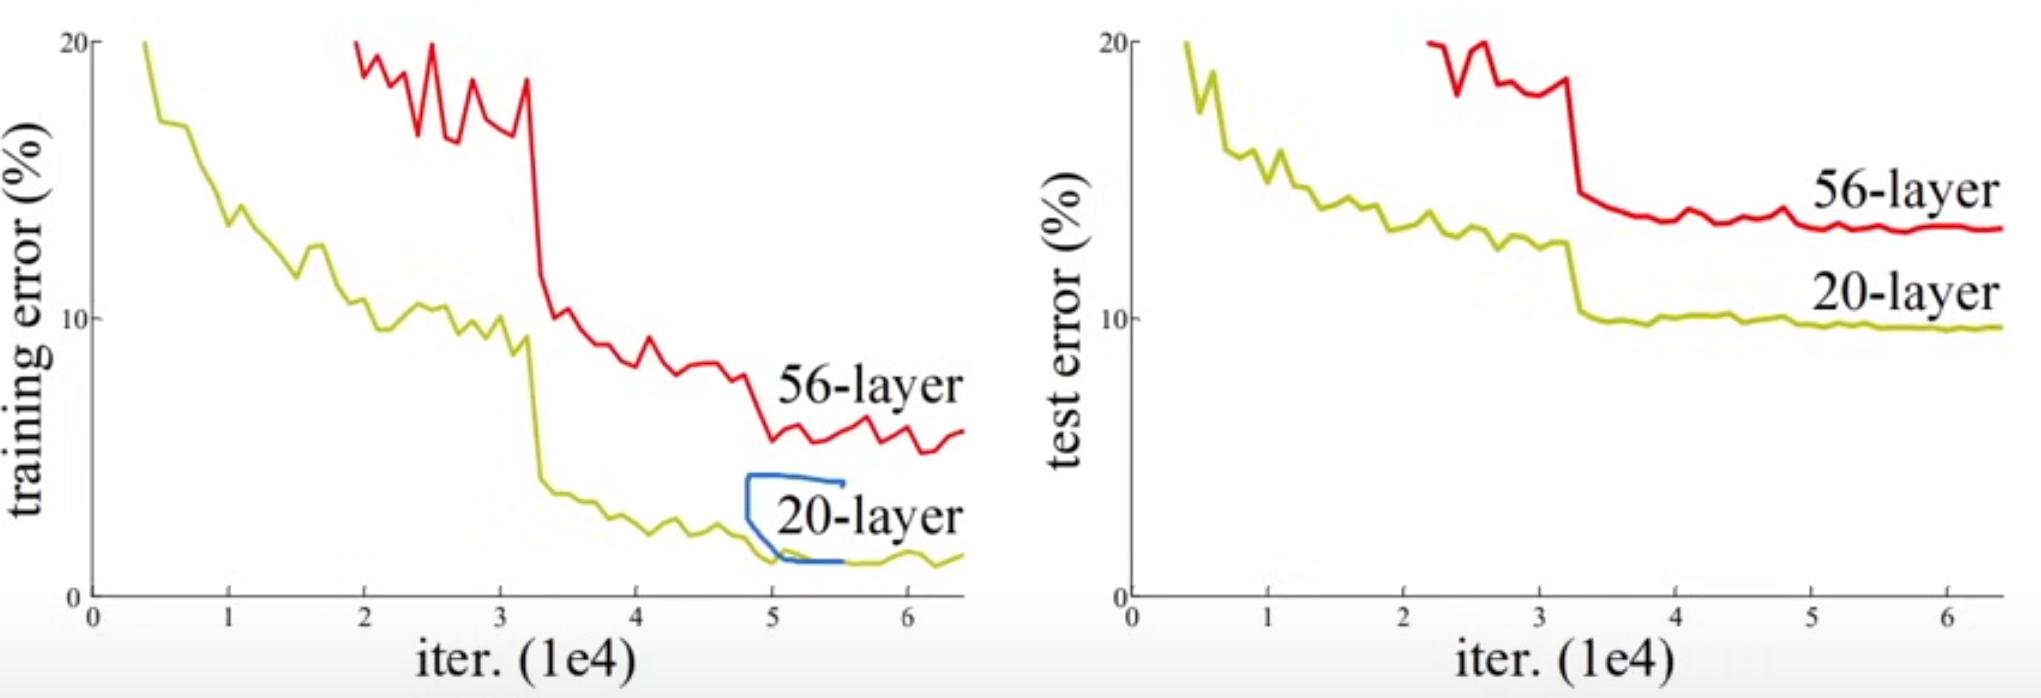

ResNet gioi thieu Residual Block, diem khac biet so voi Alex va VGG net thong thuong o cho thay vi chong cac lop Conv2D nhu binh thuong, no se chong cac 

Residual Block (ban chat residual block van la Conv2D nhung co them identity)

- Main path: duong chinh, nhanh nhay thuc hien Conv, batch normalization va activation func (Relu)

- Shortcut path: Nhanh nay duoc su dung de gradient duoc lan truyen nguoc 1 cach hieu qua, co 2 loai

    - Identity shorcut: sao chep dau vao cong truc tiep vao main path

    - Covolution shorcut: dau vao phai di qua them 1 Conv layer moi co the cong vao main path. Dieu nay la can thiet khi so luong kenh cua dau vao va dau ra khac nhau

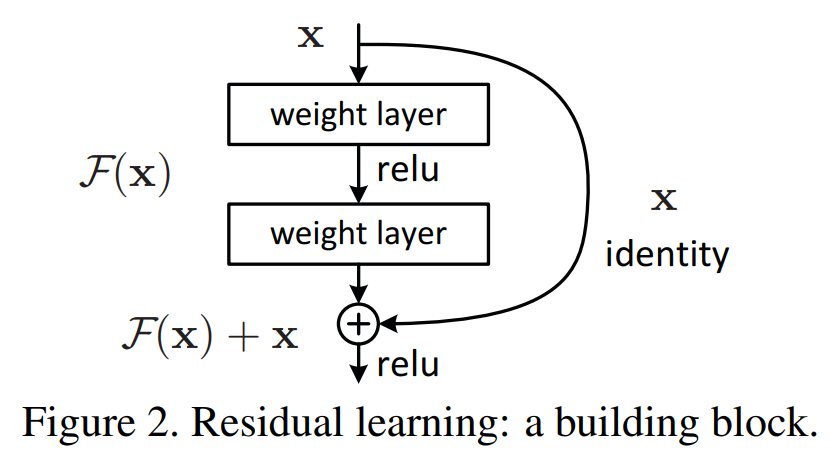

Ly do cho van de tren la hien tuong varnishing gradients trong deep learning: Trong thuat toan backpropagation, tai buoc lan truyen nguoc de xac dinh tin hieu loi, neu tin hieu loi truoc nho va dao ham ham kich hoat nho (dac biet la khi su dung tanh va sigmoid) thi tin hieu loi se nho => Cu nhu vay tin hieu loi sau nho hon tin hieu loi truoc, mang cang deep thi tin hieu loi o cac layer dau cua mang cang nho va gan nhu bang 0 => Cac lop dau tien khong hoc duoc gi

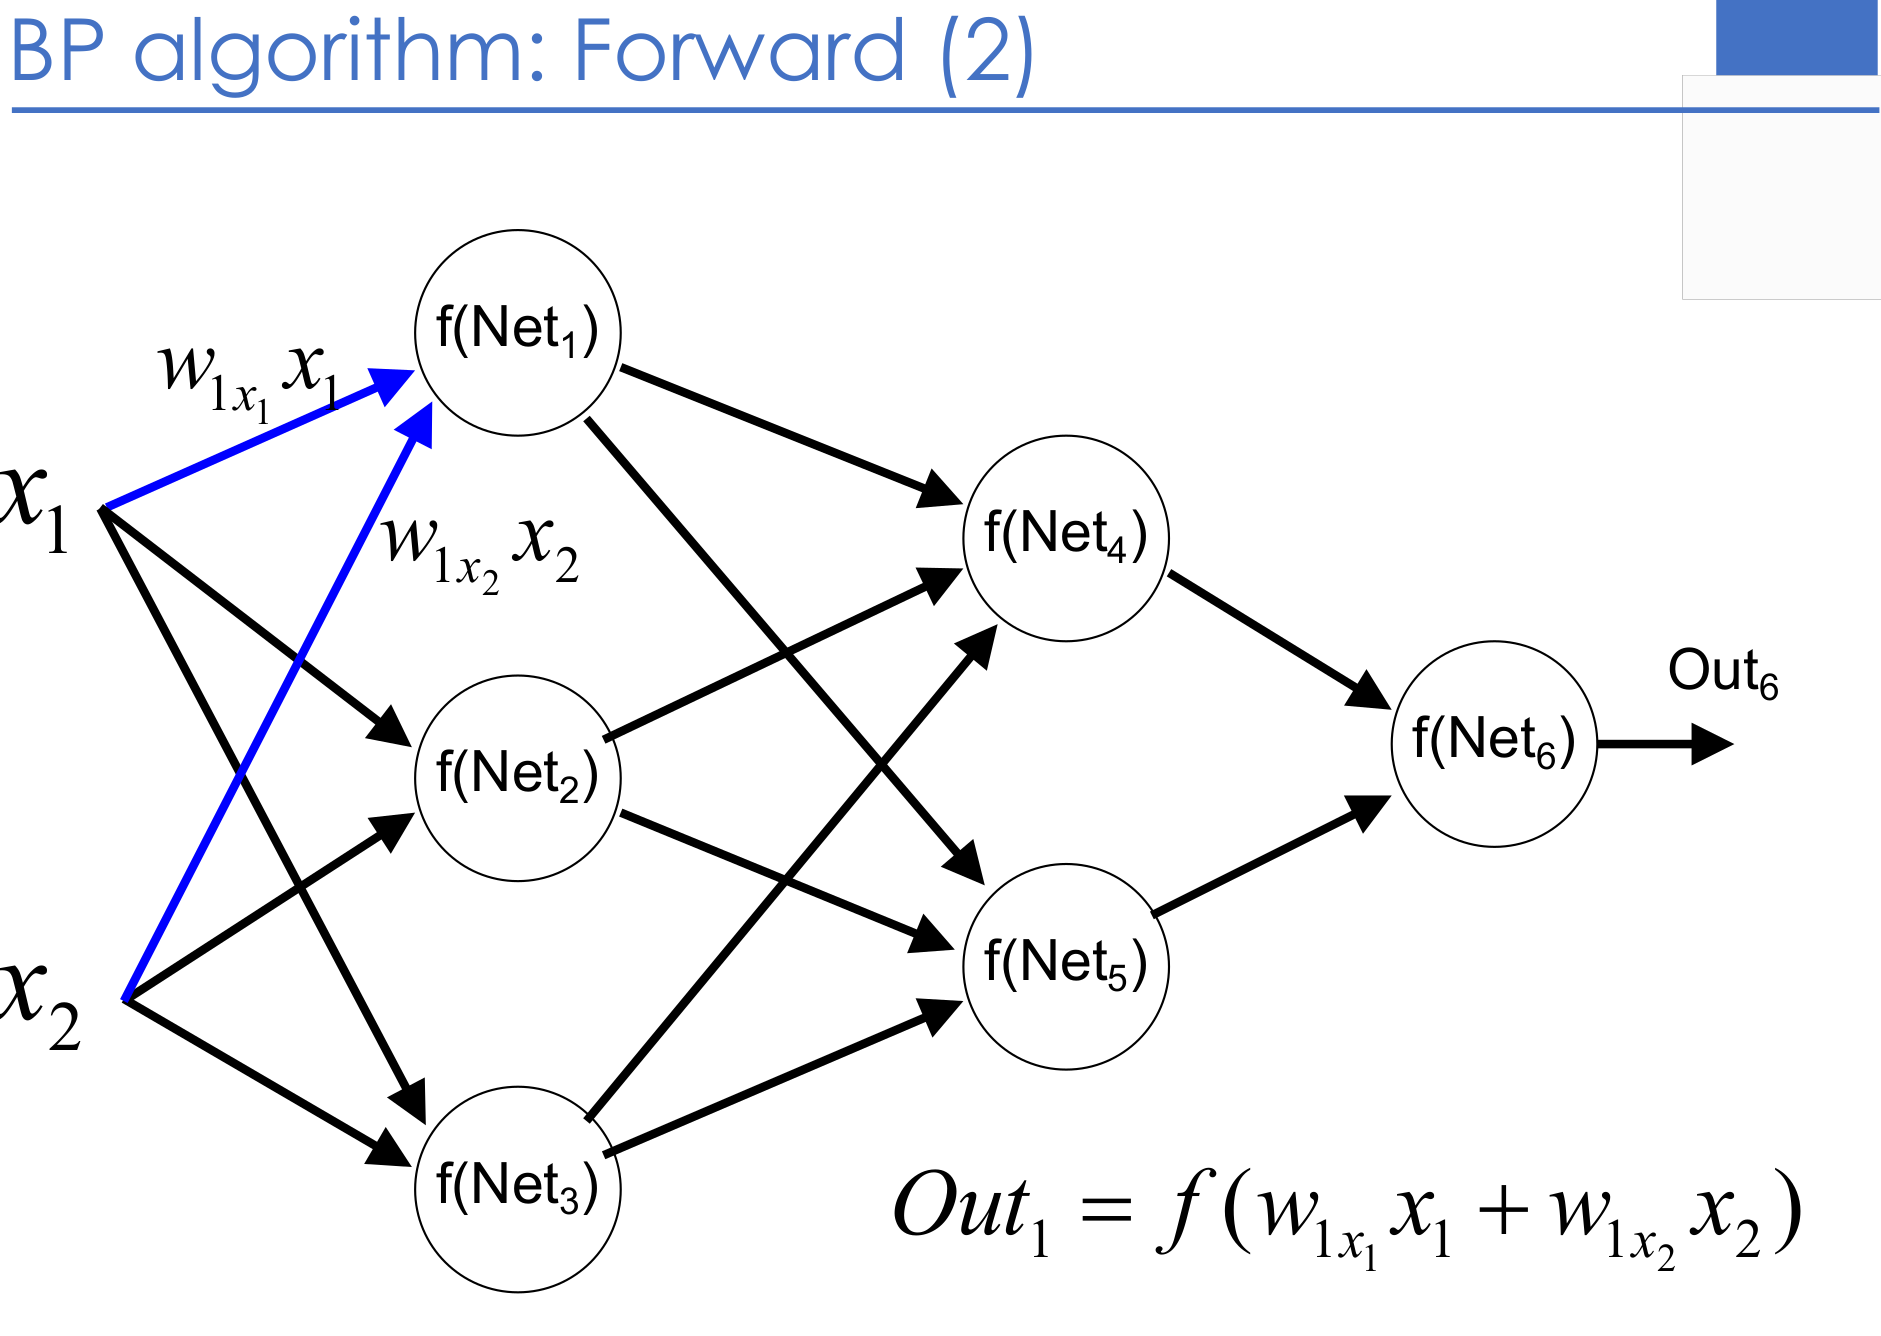

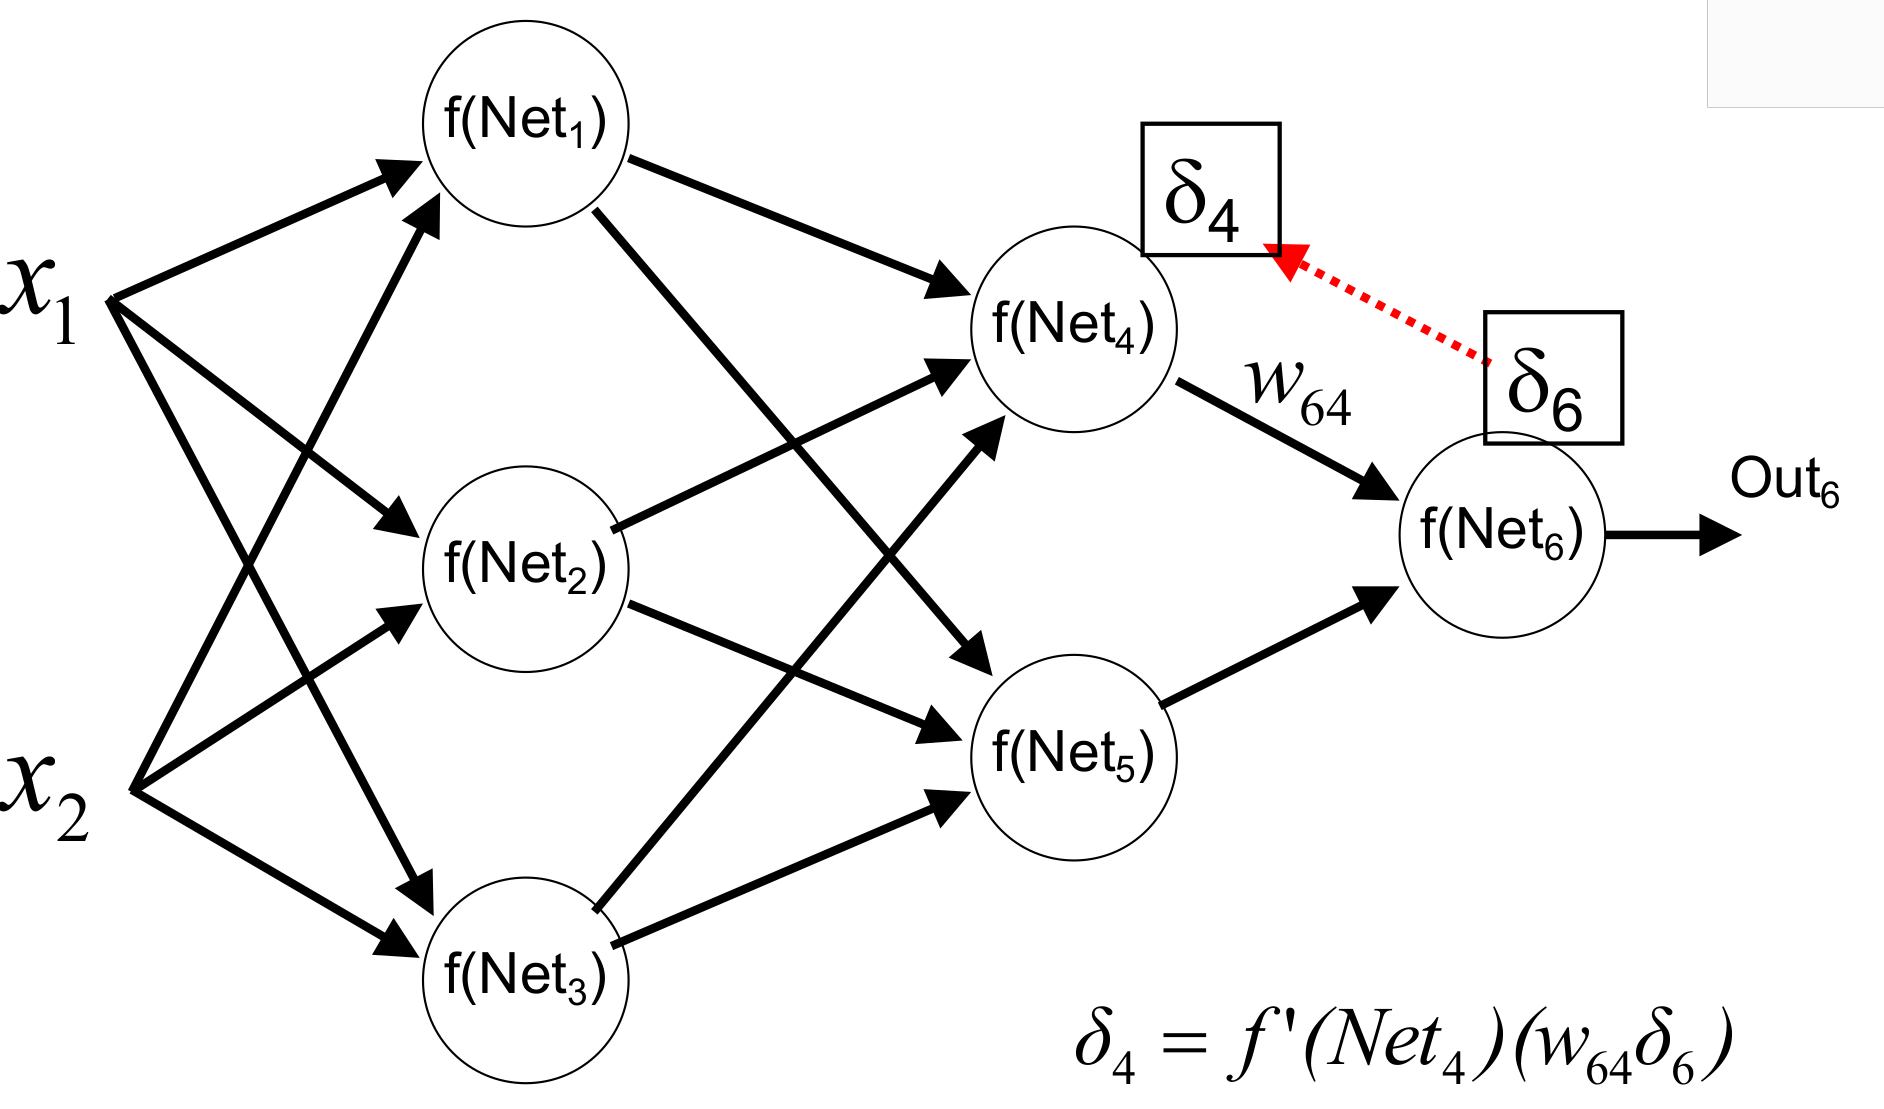

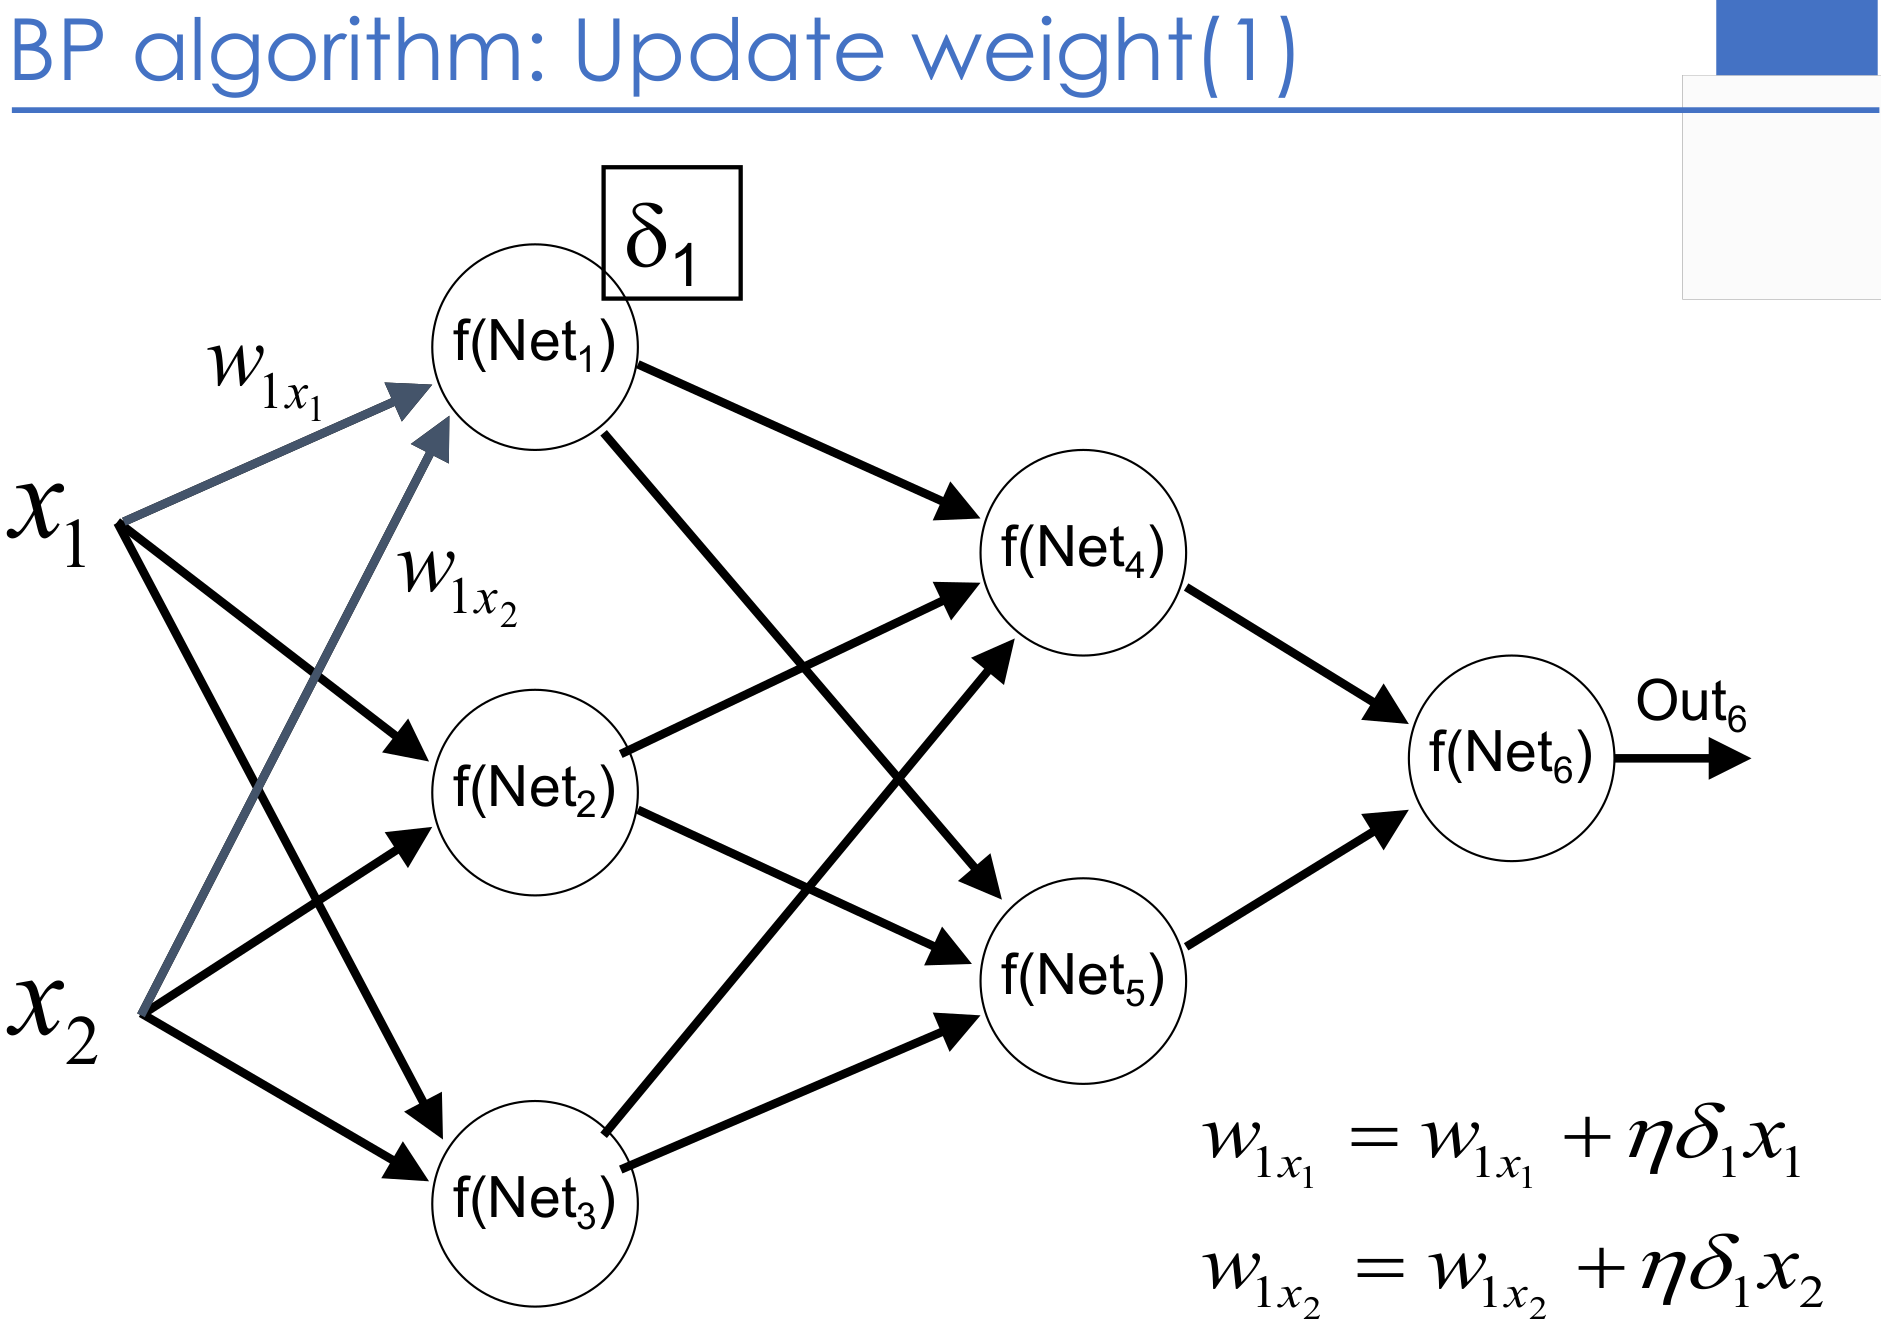

In [22]:
# Sử dụng mô hình ResNet50 từ tf.keras.applications
base_model = tf.keras.applications.ResNet50(
    include_top=False,  # Bỏ lớp fully connected cuối cùng
    weights='imagenet',  # Sử dụng trọng số đã được huấn luyện trên ImageNet
    input_shape=(CONFIGURATION['IMAGE_SIZE'][0], CONFIGURATION['IMAGE_SIZE'][1], 3)
)

# Thêm các lớp của bạn lên trên mô hình cơ bản
inputs = tf.keras.Input(shape=(CONFIGURATION['IMAGE_SIZE'][0], CONFIGURATION['IMAGE_SIZE'][1], 3))
x = base_model(inputs, training=False)  # Đặt training=False để giữ nguyên trọng số của mô hình cơ bản
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1, activation='sigmoid')(x)  # Lớp output cho bài toán phân loại nhị phân

# Tạo mô hình hoàn chỉnh
model = tf.keras.Model(inputs, x)

# Biên dịch mô hình
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# In ra cấu trúc của mô hình
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2, 2, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 23,536,641 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

## Callback

Earnly stoping callback: Dung de dung train khi phat hien hoc co dau hieu cai lui hoac khong hoc duoc gi tiep, tranh hien tuong hoc qua dan den overfitting

In [23]:
# Callback for early stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation loss
    patience=15,         # Number of epochs to wait for improvement
    verbose=1,           # Print message when stopping
    restore_best_weights=False  # Restore model weights from the epoch with the best value of the monitored quantity
)

Model checkpoint callback: Dung de luu bestmodel trong qua trinh train

In [24]:
# Callback for saving the best model based on validation accuracy
model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',  # Filepath to save the model
    monitor='val_accuracy',    # Monitor validation accuracy
    save_best_only=True,       # Save only the model with the best value of the monitored quantity
    mode='max',                # Mode for the monitored quantity ("min" or "max")
    verbose=1                  # Print message when saving the model
)

Tao Tensorboard

In [25]:
from tensorflow.keras.callbacks import TensorBoard
# Thư mục lưu trữ logs của TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# Tạo TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True)

In [26]:
# List of callbacks
callbacks = [early_stopping, model_checkpoint,tensorboard_callback]

## Compile and Train

In [27]:
metrics = [
    TruePositives(name='tp'),
    FalsePositives(name='fp'), 
    TrueNegatives(name='tn'), 
    FalseNegatives(name='fn'), 
    BinaryAccuracy(name='accuracy'), 
    Precision(name='precision'), 
    Recall(name='recall'), 
    AUC(name='auc')
]

In [28]:
model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss = BinaryCrossentropy(), 
    metrics = metrics,
)

In [29]:
history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    verbose=1,
    epochs = CONFIGURATION['N_EPOCHS'],
    callbacks=[callbacks],
)

Epoch 1/200


I0000 00:00:1718095626.402393    3990 service.cc:145] XLA service 0x78633c001410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718095626.402457    3990 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-06-11 15:47:07.267996: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-11 15:47:09.844068: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-06-11 15:47:13.847783: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 18.22GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-11 15:47:13.909278: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] A

187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8316 - auc: 0.9027 - fn: 239.5294 - fp: 185.1283 - loss: 0.4333 - precision: 0.8407 - recall: 0.8065 - tn: 1335.7273 - tp: 1247.6150

2024-06-11 15:47:44.909779: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 18.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-11 15:47:44.966090: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.57GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-11 15:47:45.353963: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.60GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8318 - auc: 0.9029 - fn: 240.3883 - fp: 185.8404 - loss: 0.4327 - precision: 0.8409 - recall: 0.8069 - tn: 1342.9202 - tp: 1254.8405
Epoch 1: val_accuracy improved from -inf to 0.70122, saving model to under_sampling/best_model.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 79s 227ms/step - accuracy: 0.8321 - auc: 0.9032 - fn: 241.2381 - fp: 186.5450 - loss: 0.4321 - precision: 0.8412 - recall: 0.8072 - tn: 1350.0370 - tp: 1261.9894 - val_accuracy: 0.7012 - val_auc: 0.6024 - val_fn: 859.0000 - val_fp: 0.0000e+00 - val_loss: 1.0130 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 2016.0000 - val_tp: 0.0000e+00
Epoch 2/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9267 - auc: 0.9761 - fn: 111.3617 - fp: 105.1543 - loss: 0.1994 - precision: 0.9243 - recall: 0.9259 - tn: 1426.3829 - tp: 1381.0905
Epoch 2: val_accuracy did not improve from 0.70122
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 101ms/step - accuracy: 0.9267 - auc: 0.

# Tensorboard

In [30]:
%load_ext tensorboard

In [32]:
tensorboard --logdir='logs'

Reusing TensorBoard on port 6006 (pid 6383), started 0:00:02 ago. (Use '!kill 6383' to kill it.)

# Model Evaluation and Testing

## Save last model

In [33]:
model.save('last_model.keras')

## Evaluation

In [34]:
last_model = tf.keras.models.load_model('last_model.keras')

In [35]:
# Dự đoán xác suất cho dữ liệu validation
last_model.evaluate(test_dataset)

1437/1437 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.9000 - auc: 0.9523 - fn: 18.7072 - fp: 56.4743 - loss: 0.3747 - precision: 0.7788 - recall: 0.9151 - tn: 452.9082 - tp: 191.4096


[0.4263962209224701,
 380.0,
 114.0,
 893.0,
 50.0,
 0.8858733177185059,
 0.7692307829856873,
 0.8837209343910217,
 0.9474214315414429]

In [36]:
# Load the model
best_model = tf.keras.models.load_model('best_model.keras')

In [37]:
best_model.evaluate(test_dataset)

1437/1437 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9174 - auc: 0.9477 - fn: 37.7740 - fp: 22.8387 - loss: 0.2928 - precision: 0.8830 - recall: 0.8265 - tn: 486.4478 - tp: 172.4388


[0.3132043480873108,
 349.0,
 45.0,
 962.0,
 81.0,
 0.9123173356056213,
 0.8857868313789368,
 0.8116279244422913,
 0.9473499059677124]

## Find Threshold

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━

2024-06-11 16:03:13.636174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


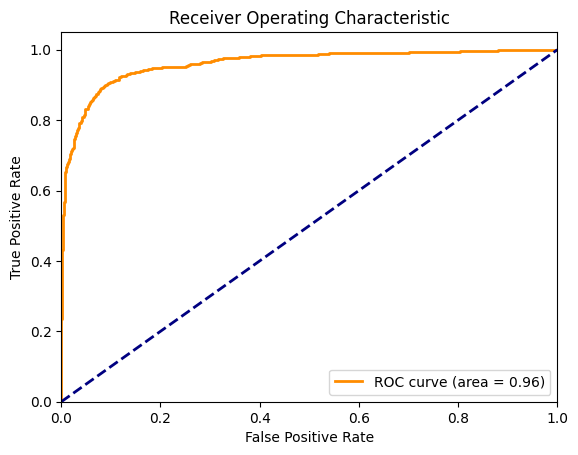

Optimal threshold:  0.1369336


In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
# Collect true labels and predicted probabilities
y_true = []
y_pred = []

for images, labels in val_dataset:
    y_true.extend(labels.numpy())
    predictions = best_model.predict(images)
    y_pred.extend(predictions.flatten())  # Flatten to make it a 1D array

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('Optimal threshold: ', optimal_threshold)

In [49]:
threshold = 0.1369336
def predict_smile_or_not(x):
    if (x < threshold):
        return str('Not Smile')
    return str('Smile')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-06-11 16:11:25.799081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


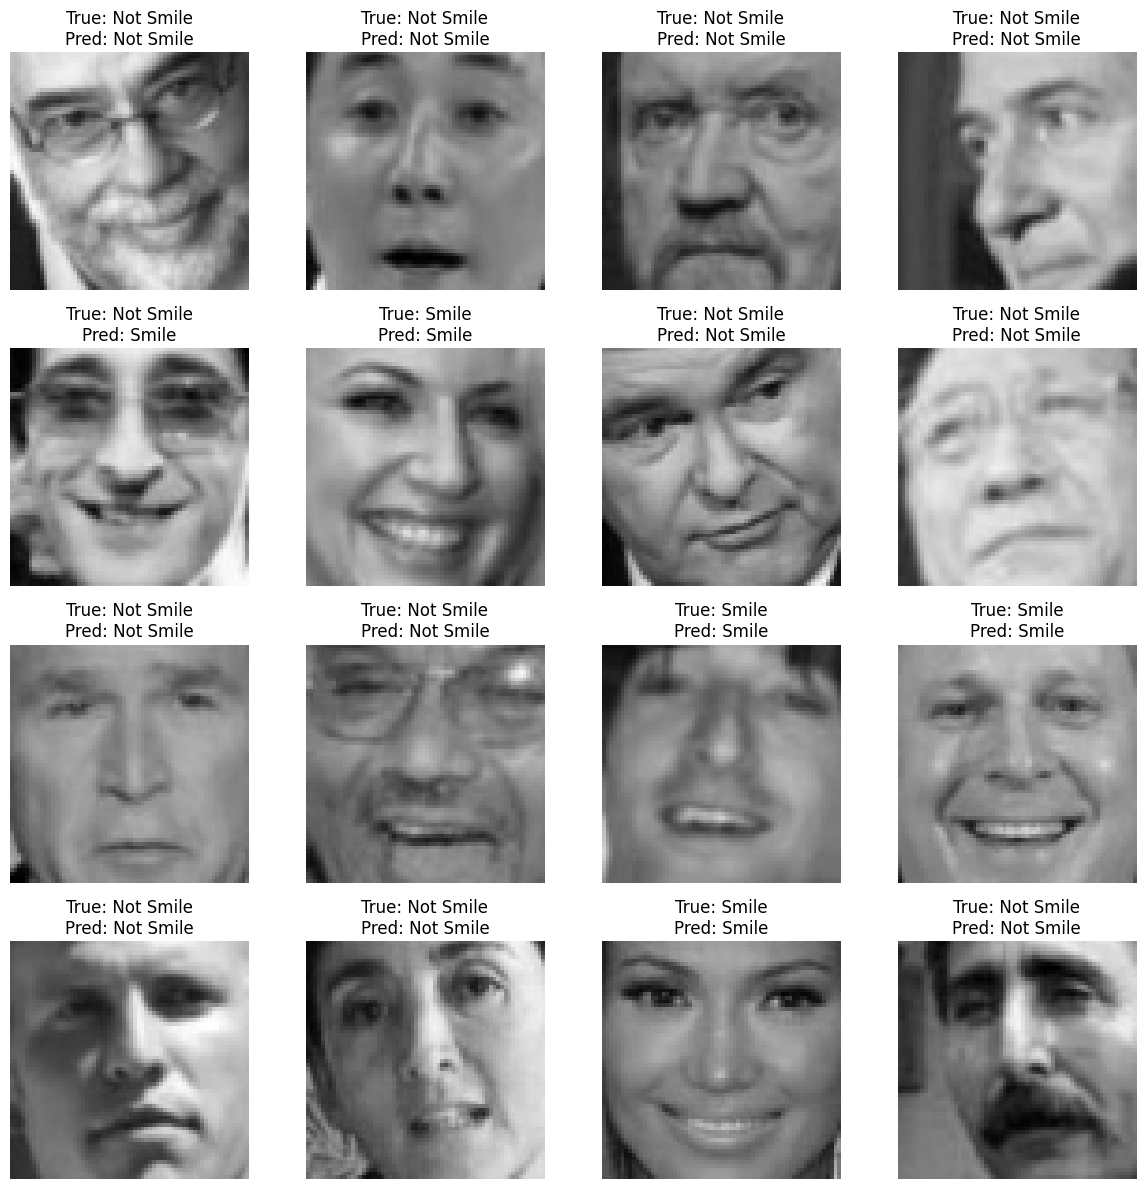

In [50]:
# Khởi tạo figure 4x4
plt.figure(figsize=(12, 12))

for index, (image, label) in enumerate(test_dataset.take(16)):
    ax = plt.subplot(4, 4, index + 1)
    # Chuyển đổi tensor ảnh thành mảng NumPy
    image_np = image.numpy()
    # Lặp qua từng ảnh trong mảng NumPy (chỉ có một ảnh mỗi lần trong test_dataset)
    plt.imshow(image_np[0])
    # Dự đoán nhãn của ảnh
    prediction = best_model.predict(image)[0][0]
    plt.title(f"True: {predict_smile_or_not(label.numpy())}\nPred: {predict_smile_or_not(prediction)}")
    plt.axis('off')

plt.tight_layout()
plt.show()

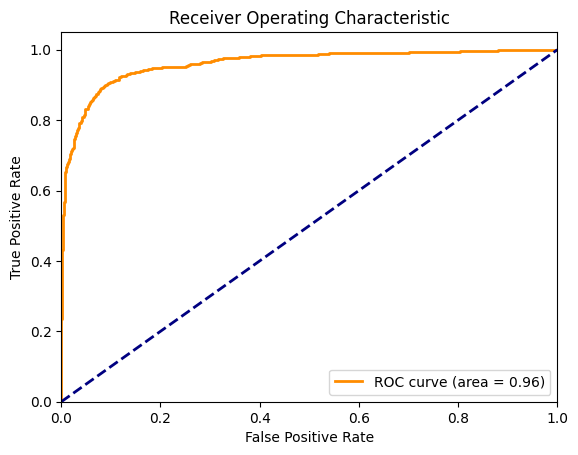

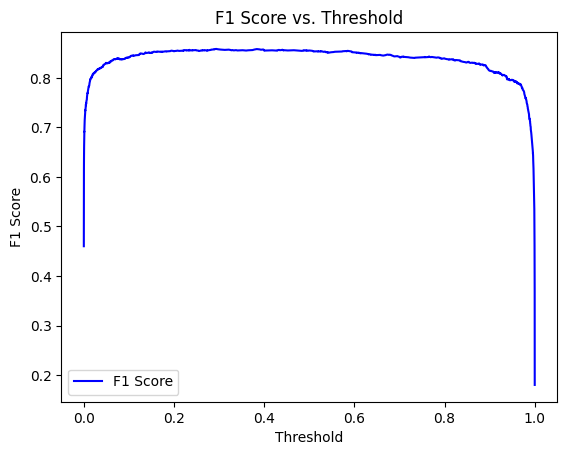

Optimal ROC threshold:  0.1369336
Optimal F1 threshold:  0.29363513
Performance with optimal ROC threshold:
Accuracy:  0.9053913043478261
Confusion Matrix: 
 [[1824  192]
 [  80  779]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.96      0.90      0.93      2016
         1.0       0.80      0.91      0.85       859

    accuracy                           0.91      2875
   macro avg       0.88      0.91      0.89      2875
weighted avg       0.91      0.91      0.91      2875

Performance with optimal F1 threshold:
Accuracy:  0.9137391304347826
Confusion Matrix: 
 [[1875  141]
 [ 107  752]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.95      0.93      0.94      2016
         1.0       0.84      0.88      0.86       859

    accuracy                           0.91      2875
   macro avg       0.89      0.90      0.90      2875
weighted avg       0.91      0.91      0.91      2

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, accuracy_score, confusion_matrix, classification_report, f1_score

# Tính toán ROC curve và ngưỡng tối ưu
fpr, tpr, thresholds_roc = roc_curve(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)
optimal_idx_roc = np.argmax(tpr - fpr)
optimal_threshold_roc = thresholds_roc[optimal_idx_roc]

# Vẽ ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Tính toán Precision-Recall curve và F1 score
precisions, recalls, thresholds_pr = precision_recall_curve(y_true, y_pred)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
optimal_f1_idx = np.argmax(f1_scores)
optimal_f1_threshold = thresholds_pr[optimal_f1_idx]

# Vẽ F1 score theo ngưỡng
plt.figure()
plt.plot(thresholds_pr, f1_scores[:-1], 'b', label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.legend(loc='best')
plt.show()

print('Optimal ROC threshold: ', optimal_threshold_roc)
print('Optimal F1 threshold: ', optimal_f1_threshold)

# Áp dụng ngưỡng tối ưu để phân loại và đánh giá
y_pred_class_roc = (y_pred >= optimal_threshold_roc).astype(int)
y_pred_class_f1 = (y_pred >= optimal_f1_threshold).astype(int)

# Đánh giá hiệu suất với ngưỡng ROC
accuracy_roc = accuracy_score(y_true, y_pred_class_roc)
conf_matrix_roc = confusion_matrix(y_true, y_pred_class_roc)
class_report_roc = classification_report(y_true, y_pred_class_roc)

print('Performance with optimal ROC threshold:')
print('Accuracy: ', accuracy_roc)
print('Confusion Matrix: \n', conf_matrix_roc)
print('Classification Report: \n', class_report_roc)

# Đánh giá hiệu suất với ngưỡng F1
accuracy_f1 = accuracy_score(y_true, y_pred_class_f1)
conf_matrix_f1 = confusion_matrix(y_true, y_pred_class_f1)
class_report_f1 = classification_report(y_true, y_pred_class_f1)

print('Performance with optimal F1 threshold:')
print('Accuracy: ', accuracy_f1)
print('Confusion Matrix: \n', conf_matrix_f1)
print('Classification Report: \n', class_report_f1)


## Test với mặt thật

In [45]:
# Convert toàn bộ ảnh màu sang grayscale

# Đường dẫn tới thư mục chứa ảnh màu
input_dir = 'testset'
# Đường dẫn tới thư mục lưu ảnh grayscale
output_dir = 'testset-gray'

# Tạo thư mục lưu ảnh grayscale nếu chưa tồn tại
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
       
# Duyệt qua từng ảnh trong thư mục hiện tại
for filename in os.listdir(input_dir):
    image_path = os.path.join(input_dir, filename)
    # Đọc ảnh màu
    image = cv2.imread(image_path)
    # Chuyển đổi sang ảnh grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Lưu ảnh grayscale vào thư mục đích
    output_image_path = os.path.join(output_dir, filename)
    cv2.imwrite(output_image_path, gray_image)

Current working directory: /media/vohoang/Workspace/wsl2/project2/4. final project/final/model
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


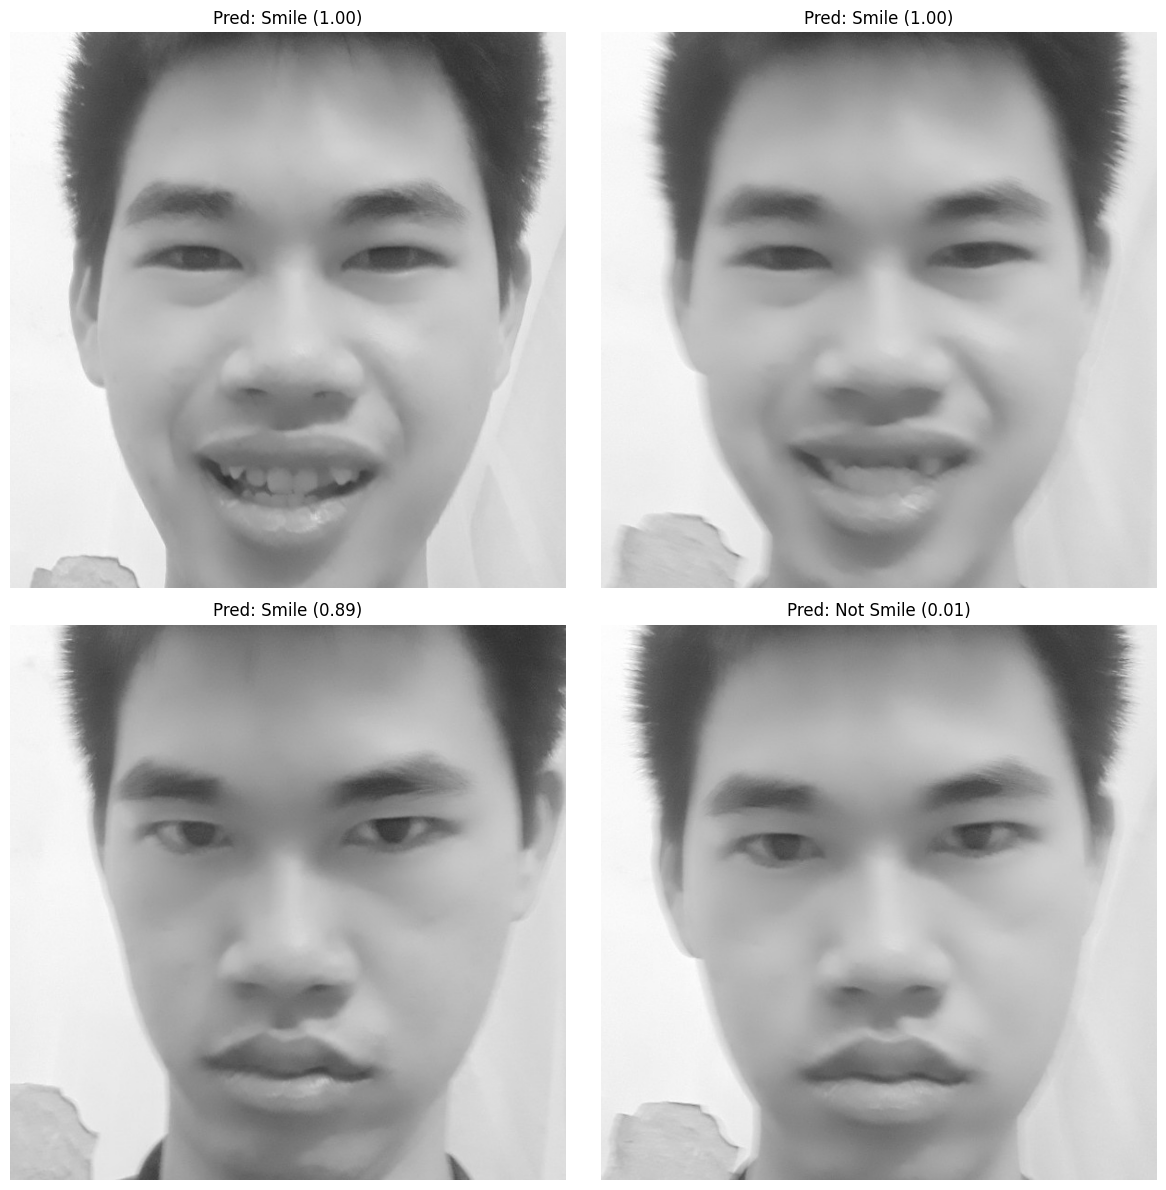

In [48]:
# Danh sách file ảnh
image_files = ['testset-gray/1.jpg', 'testset-gray/2.jpg', 'testset-gray/3.jpg', 'testset-gray/5.jpg']

# Kiểm tra đường dẫn hiện tại
print("Current working directory:", os.getcwd())

# Khởi tạo figure với kích thước phù hợp cho số lượng ảnh
num_images = len(image_files)
num_cols = 2  # Số cột
num_rows = (num_images + num_cols - 1) // num_cols  # Số hàng

plt.figure(figsize=(12, 6 * num_rows))

for index, image_file in enumerate(image_files):
    # Chuyển đổi đường dẫn tương đối thành đường dẫn tuyệt đối
    absolute_path = os.path.abspath(image_file)
    if not os.path.exists(absolute_path):
        print(f"File not found: {image_file}")
    else:
        # Load và tiền xử lý ảnh
        image = cv2.imread(absolute_path)
        # Hiển thị ảnh và tiêu đề
        plt.subplot(num_rows, num_cols, index + 1)
        plt.imshow(image, cmap='gray')  # Sử dụng cmap='gray' để hiển thị ảnh grayscale
        plt.axis('off')
        
        image = cv2.resize(image, tuple(CONFIGURATION['IMAGE_SIZE']))  # Thay đổi kích thước ảnh
        image_np = image / 255.0  # Chuẩn hóa ảnh
        image_np = np.expand_dims(image_np, axis=0)  # Thêm chiều batch

        # Dự đoán nhãn của ảnh
        prediction = model.predict(image_np)[0][0]
        label = predict_smile_or_not(prediction)

        plt.title(f"Pred: {label} ({prediction:.2f})")

plt.tight_layout()
plt.show()